# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# 1)

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  prior_probability = prob_drunk_prior
  p_drunk = prior_probability
  p_positive_given_drunk = true_positive_rate
  p_positive_given_not_drunk = false_positive_rate
  p_not_drunk = 1 - p_drunk

  posterior_probability = (p_positive_given_drunk * p_drunk) / ((p_positive_given_drunk * p_drunk) + (p_positive_given_not_drunk) * p_not_drunk)
  return posterior_probability


In [5]:
done = False
rounds = 0
prior_belief = 1/1000
false_positive = 0.08
true_positive = 1

while done is False:
  rounds += 1
  prob = prob_drunk_given_positive(prior_belief, false_positive, true_positive)
  print(f'Round {rounds}: Probability - {prob}')
  if prob >= 0.95:
    done = True
  prior_belief = prob

Round 1: Probability - 0.012357884330202669
Round 2: Probability - 0.13525210993291495
Round 3: Probability - 0.6615996951348605
Round 4: Probability - 0.9606895076105054


In [0]:
# An extra because wanted to plot the probabilities

probabilities = []
prior_belief = 1/1000

for i in range(25):
  prob = prob_drunk_given_positive(prior_belief, false_positive, true_positive)
  probabilities.append(prob)
  prior_belief = prob


In [16]:
print(probabilities)

[0.012357884330202669, 0.13525210993291495, 0.6615996951348605, 0.9606895076105054, 0.9967371577896734, 0.9997381867081508, 0.9999790498904363, 0.9999983239589307, 0.9999998659165077, 0.9999999892733192, 0.9999999991418655, 0.9999999999313492, 0.999999999994508, 0.9999999999995607, 0.9999999999999648, 0.9999999999999972, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


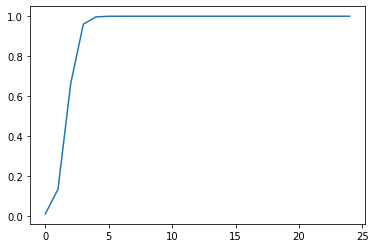

In [18]:
import matplotlib.pyplot as plt

plt.plot(probabilities)

In [33]:
# 2)

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

--2020-01-15 23:07:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data.2’

wdbc.data.2         100%[===================>] 121.19K   312KB/s    in 0.4s    

2020-01-15 23:07:38 (312 KB/s) - ‘wdbc.data.2’ saved [124103/124103]



In [0]:
import pandas as pd

columns = ['ID', 'Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'Concave Points', 'Symmetry', 'Fractal Dimension', 'Radius1', 'Texture1', 'Perimeter1', 'Area1', 'Smoothness1', 'Compactness1', 'Concavity1', 'Concave Points1', 'Symmetry1', 'Fractal Dimension1', 'Radius2', 'Texture2', 'Perimeter2', 'Area2', 'Smoothness2', 'Compactness2', 'Concavity2', 'Concave Points2', 'Symmetry2', 'Fractal Dimension2']

df = pd.read_csv('wdbc.data', header=None, names=columns)

In [41]:
df.head()

,ID,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension,Radius1,Texture1,Perimeter1,Area1,Smoothness1,Compactness1,Concavity1,Concave Points1,Symmetry1,Fractal Dimension1,Radius2,Texture2,Perimeter2,Area2,Smoothness2,Compactness2,Concavity2,Concave Points2,Symmetry2,Fractal Dimension2
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [42]:
df.drop(['Radius1', 'Texture1', 'Perimeter1', 'Area1', 'Smoothness1', 'Compactness1', 'Concavity1', 'Concave Points1', 'Symmetry1', 'Fractal Dimension1', 'Radius2', 'Texture2', 'Perimeter2', 'Area2', 'Smoothness2', 'Compactness2', 'Concavity2', 'Concave Points2', 'Symmetry2', 'Fractal Dimension2'], axis=1)

,ID,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


In [43]:
df['Diagnosis'] = df['Diagnosis'].replace({'M': 1, 'B': 0})
df.head()

,ID,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension,Radius1,Texture1,Perimeter1,Area1,Smoothness1,Compactness1,Concavity1,Concave Points1,Symmetry1,Fractal Dimension1,Radius2,Texture2,Perimeter2,Area2,Smoothness2,Compactness2,Concavity2,Concave Points2,Symmetry2,Fractal Dimension2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [44]:
df['Diagnosis'].describe()

count    569.000000
mean       0.372583
std        0.483918
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Diagnosis, dtype: float64

In [45]:
df['Radius'].describe()

count    569.000000
mean      14.127292
std        3.524049
min        6.981000
25%       11.700000
50%       13.370000
75%       15.780000
max       28.110000
Name: Radius, dtype: float64

In [50]:
malignant = df[df['Diagnosis'] == 1]
malignant['Radius'].describe()

count    212.000000
mean      17.462830
std        3.203971
min       10.950000
25%       15.075000
50%       17.325000
75%       19.590000
max       28.110000
Name: Radius, dtype: float64

In [51]:
benign = df[df['Diagnosis'] == 0]
benign['Radius'].describe()

count    357.000000
mean      12.146524
std        1.780512
min        6.981000
25%       11.080000
50%       12.200000
75%       13.370000
max       17.850000
Name: Radius, dtype: float64

In [0]:
from scipy import stats

In [61]:
# Confidence interval for radius mean for malignant tumours
mean_m_radius_confidence_interval, _, _ = stats.bayes_mvs(malignant['Radius'], alpha=0.95) 

mean_m_radius_confidence_interval

Mean(statistic=17.462830188679245, minmax=(17.02905279535662, 17.89660758200187))

In [56]:
# Confidence interval for radius mean for benign tumours
mean_b_radius_confidence_interval, _, _ = stats.bayes_mvs(benign['Radius'], alpha=0.95) 

mean_b_radius_confidence_interval

Mean(statistic=12.146523809523808, minmax=(11.961197197671318, 12.331850421376298))

In [62]:
print(mean_m_radius_confidence_interval[0] - mean_m_radius_confidence_interval[1][0])
print(mean_m_radius_confidence_interval[1][1] - mean_m_radius_confidence_interval[0])

0.4337773933226252
0.4337773933226252


In [0]:
import matplotlib.pyplot as plt

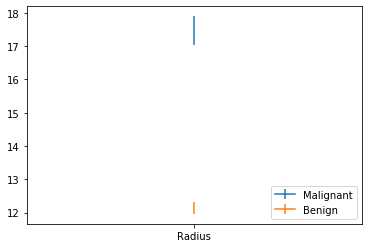

In [64]:
fig = plt.figure()

x = ['Radius']

# Malignant info.
y_m = mean_m_radius_confidence_interval[0]
yerr_m = mean_m_radius_confidence_interval[0] - mean_m_radius_confidence_interval[1][0] # size of error

# Benign info.
y_b = mean_b_radius_confidence_interval[0]
yerr_b = mean_b_radius_confidence_interval[0] - mean_b_radius_confidence_interval[1][0] # size of error

plt.errorbar(x, y_m, yerr=yerr_m, label='Malignant')
plt.errorbar(x, y_b, yerr=yerr_b, label='Benign')

plt.legend(loc='lower right');

In [66]:
# Compare the two means 
from scipy.stats import ttest_ind

ttest_ind(malignant['Radius'], benign['Radius'], nan_policy='omit')

Ttest_indResult(statistic=25.435821610057054, pvalue=8.465940572262422e-96)

In [0]:
# P < 0.01 - Reject null hypothesis that means are equal. Malignant 
# tumours have bigger radius

In [68]:
import numpy as np

# Check whether Diagnosis is independent from Radius (doubt it)

# Create the contingency table

observed = pd.crosstab(df['Diagnosis'], df['Radius'])
observed = np.array(observed)
observed

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 3,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2,
        1, 1, 1, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1,
        1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        3, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 

In [70]:
# Conduct chi-squared test

chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f'Chi-squared: {chi_squared}')
print(f'P-value: {p_value}')
print(f'Degrees of Freedom: {dof}')

Chi-squared: 513.7450859274527
P-value: 0.029296084732761095
Degrees of Freedom: 455


In [0]:
# P > 0.01 - Fail to reject null hypothesis that diagnosis is independent
# from radius.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!